In [1]:
import torch
from math import pi
import einops as einops
from training.utils.FLAIR_2 import*
import matplotlib.pyplot as plt
from training.perceiver import*
from training.utils import*
from training.losses import*
from training.VIT import*
from training.ResNet import*
from collections import defaultdict
from training import*

/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()


In [2]:
config_path = "./data/flair_2_toy_dataset/flair-2-config.yml" # Change to yours
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [3]:
config_model = read_yaml("./training/configs/config_test-Atomiser_Atos.yaml")
trans_config=transformations_config_flair("./data/bands_info/bands.yaml",config_model)

In [4]:
config_model

{'encoder': 'Atomiser',
 'dataset': {'batchsize': 1},
 'trainer': {'lr': '1e-4',
  'dropout': 0.5,
  'epochs': 1,
  'logging_step': 10,
  'num_classes': 19,
  'weight_decay': 0.0,
  'multi_modal': True},
 'Atomiser': {'depth': 8,
  'num_latents': 512,
  'latent_dim': 512,
  'cross_heads': 1,
  'latent_heads': 8,
  'cross_dim_head': 64,
  'latent_dim_head': 64,
  'attn_dropout': 0.0,
  'ff_dropout': 0.0,
  'weight_tie_layers': False,
  'fourier_encode_data': False,
  'self_per_cross_attn': 1,
  'final_classifier_head': True,
  'input_channels': 22,
  'masking': 0,
  'date_encoding': 'NOPE',
  'bandvalue_encoding': 'NATURAL',
  'wavelength_encoding': 'NATURAL',
  'pos_encoding': 'FF',
  'pos_num_freq_bands': 4,
  'pos_max_freq': 4,
  'wavelength_num_freq_bands': 4,
  'wavelength_max_freq': 4}}

In [5]:
data_flair=CustomFLAIR(file_path="./data/custom_flair/tiny_train.h5",trans_config=trans_config)

In [6]:
_=data_flair[0]

In [7]:
labels=load_json_to_dict("./data/flair_2_toy_dataset/flair_labels.json")

In [8]:
model=Model(config_model, wand=None, name="test_hoho",labels=labels,img_shape=None)
data_flair=CustomFLAIR(file_path="./data/custom_flair/tiny_train.h5",trans_config=trans_config,model=model)


In [9]:
_=data_flair[0]

In [10]:
xp_name="test_xp"
config_model = "Atomiser_Atos"
config_name_dataset = "tiny"
config_name_dataset= "./data/custom_flair/"+config_name_dataset
from pytorch_lightning import Trainer,seed_everything
from pytorch_lightning.callbacks import EarlyStopping

seed_everything(42, workers=True)

torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')

config_model = read_yaml("./training/configs/config_test-"+config_model+".yaml")
labels=load_json_to_dict("./data/flair_2_toy_dataset/flair_labels.json")
bands_yaml = "./data/Tiny_BigEarthNet/bands.yaml"

trans_config=transformations_config_flair("./data/bands_info/bands.yaml",config_model)




wand = False
wandb_logger = None
if wand:
    if os.environ.get("LOCAL_RANK", "0") == "0":
        import wandb
        wandb.init(
            name=get_xp_name(config_model['encoder']) + " modalities",
            project=config_name_dataset+"_modalities",
            config=config_model
        )
        wandb_logger = WandbLogger(project=config_name_dataset+"_modalities")
       


model = Model(config_model, wand=wand, name=xp_name,labels=labels)

#(self, path,config,trans_config,model, batch_size=8, num_workers=4)
data_module=CustomFlairDataModule(config_name_dataset,
                      config=config_model,
                      trans_config=trans_config,
                      model=model,
                      batch_size=config_model['dataset']['batchsize'],
                    )


early_stop_callback = EarlyStopping(monitor="val_ap", min_delta=0.00, patience=15, verbose=False, mode="max")
# Configure the trainer for distributed training.
trainer = Trainer(
    use_distributed_sampler=False,  # we use our custom sampler
    #strategy="ddp",
    max_epochs=config_model["trainer"]["epochs"],
    logger=wandb_logger,
    log_every_n_steps=1,
    #devices=1,
    accelerator="cpu",
    callbacks=[early_stop_callback]
)

trainer.fit(model, datamodule=data_module)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name       | Type                   | Params | Mode 
-----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packag

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hugoriffaud/Documents/FLAIR_Ato/venv/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack(): functions with out=... arguments don't support automatic differentiation, but one of the arguments requires grad.


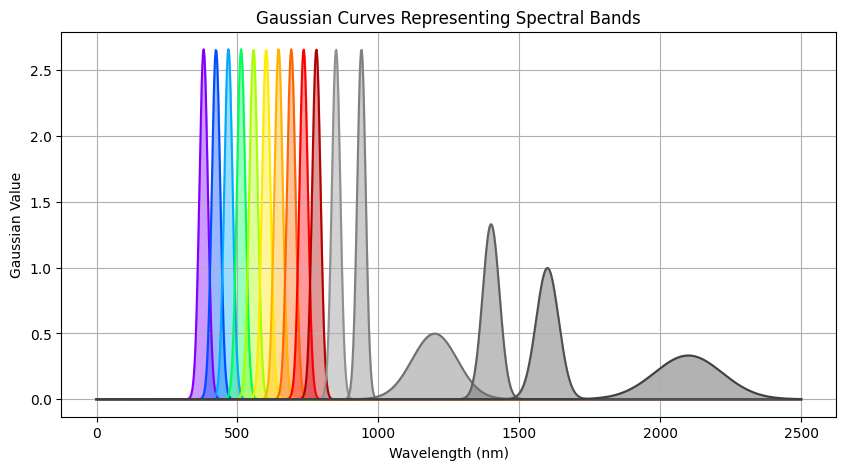

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians_with_fill(centers, stds,colors, num_points=1000):
    """
    Plots multiple Gaussian curves with shaded areas under each curve.

    Parameters:
    - centers: List of mean values for each Gaussian.
    - stds: List of standard deviations for each Gaussian.
    - num_points: Number of points to sample in the range.
    """
    x = np.linspace(0, 2500, num_points)  # Extended range to fit all wavelengths
    
    plt.figure(figsize=(10, 5))
    
    for idx,(mu, sigma) in enumerate(zip(centers, stds)):
        y = np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * 100
        plt.plot(x, y, label=f'$\mu$={mu}, $\sigma$={sigma}',color=colors[idx])
        plt.fill_between(x, y, alpha=0.4,color=colors[idx])  # Fill area under the curve
    
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Gaussian Value")
    plt.title("Gaussian Curves Representing Spectral Bands")
    #plt.legend()
    plt.grid()
    plt.savefig("gaussians.pdf")
    plt.show()
    

# Central wavelengths (centers of Gaussians)
VIS=[380, 424, 468, 513, 557, 602, 646, 691, 735, 780,850,940]
middle=[1200,1400,1600]
centers = VIS+middle+[2100]

# Bandwidths (used as standard deviations)
VIS_std=[15,15,15,15,15,15,15,15,15,15,15,15]
middle_std=[80,30,40]
stds = VIS_std+middle_std+[120]
colors = [
    '#8000ff',  # 380 nm (Violet)
    '#004cff',  # 424 nm (Deep Blue)
    '#00aaff',  # 468 nm (Cyan-Blue)
    '#00ff59',  # 513 nm (Green-Cyan)
    '#a8ff00',  # 557 nm (Green-Yellow)
    '#ffea00',  # 602 nm (Yellow)
    '#ffb300',  # 646 nm (Orange)
    '#ff6500',  # 691 nm (Red-Orange)
    '#ff0000',  # 735 nm (Deep Red)
    '#b30000',  # 780 nm (Very Deep Red)
    '#909090',  # 850 nm (NIR, grey)
    '#808080',  # 940 nm (NIR, darker grey)
    '#707070',  # 1030 nm
    '#606060',  # 1200 nm
    '#505050',  # 1400 nm
    '#404040',  # 1600 nm
    '#303030'   # 2100 nm
]



# Plot the Gaussians with filled areas
plot_gaussians_with_fill(centers, stds,colors)


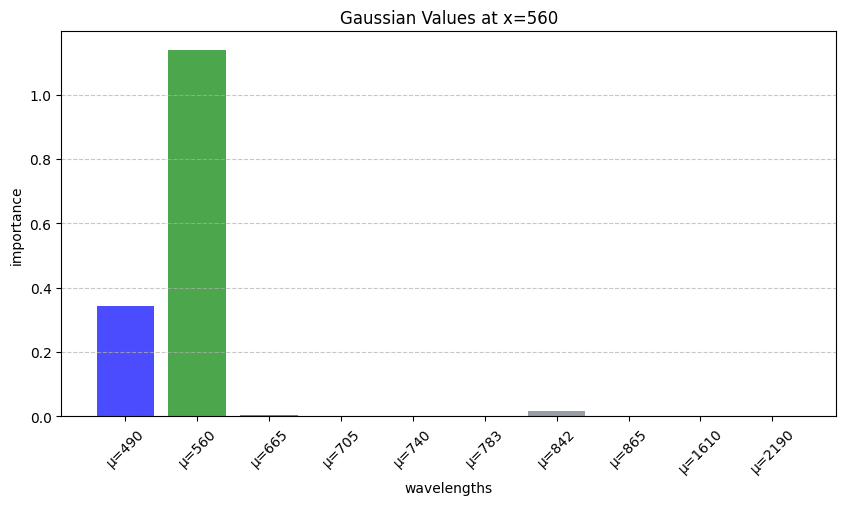

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def compute_gaussian_values(x, centers, stds):
    """
    Computes the value of each Gaussian function at a given x.

    Parameters:
    - x: The input value at which to evaluate the Gaussians.
    - centers: List of mean values for each Gaussian.
    - stds: List of standard deviations for each Gaussian.

    Returns:
    - List of Gaussian function values at x.
    """
    gaussian_values = [
        np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * 100
        for mu, sigma in zip(centers, stds)
    ]
    return gaussian_values

# Given parameters
centers = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]
stds = [65, 35, 30, 15, 15, 20, 115, 20, 90, 180]
colors = ['blue', 'green', 'red', '#7f7f7f', '#a5a5a5', '#adb5bd', '#6c757d', '#495057', '#343a40', '#212529']

# Example x value
x_value = 560

# Compute Gaussian values at x
gaussian_values_at_x = compute_gaussian_values(x_value, centers, stds)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(centers)), gaussian_values_at_x, color=colors, alpha=0.7)

# Labeling
plt.xticks(range(len(centers)), [f'μ={mu}' for mu in centers], rotation=45)
plt.xlabel("wavelengths")
plt.ylabel("importance")
plt.title(f"Gaussian Values at x={x_value}")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/var/folders/kh/8xx46fmx42n0vd2989f_jgwr0000gn/T/ipykernel_3640/257595150.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


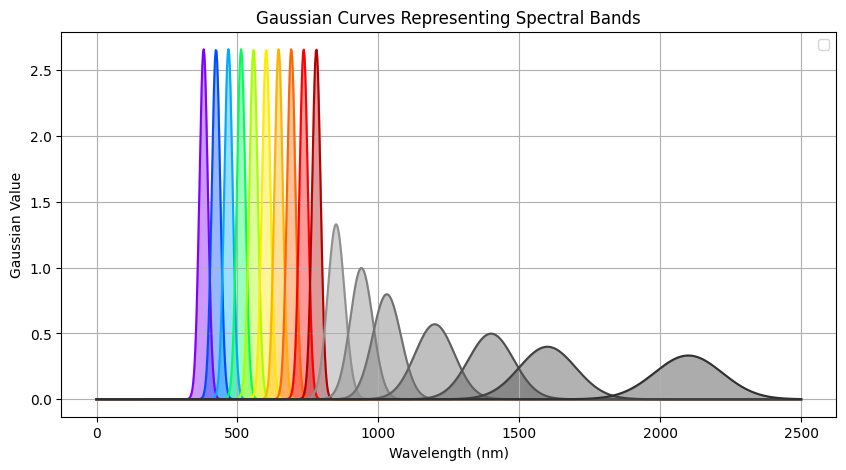

In [42]:
np.linspace(780,1100,2,dtype=int)

array([ 780, 1100])

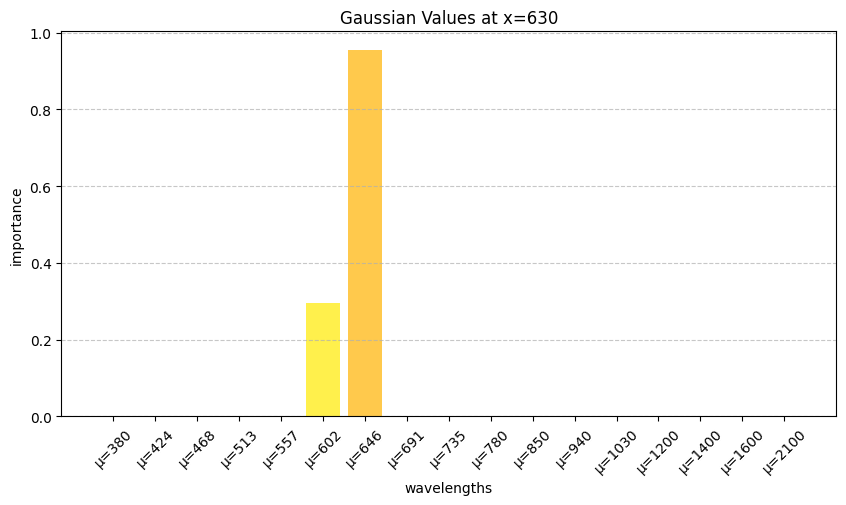

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def compute_gaussian_values(x, centers, stds):
    """
    Computes the value of each Gaussian function at a given x.

    Parameters:
    - x: The input value at which to evaluate the Gaussians.
    - centers: List of mean values for each Gaussian.
    - stds: List of standard deviations for each Gaussian.

    Returns:
    - List of Gaussian function values at x.
    """
    gaussian_values = [
        np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) * 100
        for mu, sigma in zip(centers, stds)
    ]
    return gaussian_values

# Given parameters
# Central wavelengths (centers of Gaussians)
centers = [380, 424, 468, 513, 557, 602, 646, 691, 735, 780,850,940,1030,1200,1400,1600,2100]

# Bandwidths (used as standard deviations)
stds = [15,15,15,15,15,15,15,15,15,15,30,40,50,70,80,100,120]
colors = [
    '#8000ff',  # 380 nm (Violet)
    '#004cff',  # 424 nm (Deep Blue)
    '#00aaff',  # 468 nm (Cyan-Blue)
    '#00ff59',  # 513 nm (Green-Cyan)
    '#a8ff00',  # 557 nm (Green-Yellow)
    '#ffea00',  # 602 nm (Yellow)
    '#ffb300',  # 646 nm (Orange)
    '#ff6500',  # 691 nm (Red-Orange)
    '#ff0000',  # 735 nm (Deep Red)
    '#b30000',  # 780 nm (Very Deep Red)
    '#909090',  # 850 nm (NIR, grey)
    '#808080',  # 940 nm (NIR, darker grey)
    '#707070',  # 1030 nm
    '#606060',  # 1200 nm
    '#505050',  # 1400 nm
    '#404040',  # 1600 nm
    '#303030'   # 2100 nm
]
# Example x value
x_value = 630

# Compute Gaussian values at x
gaussian_values_at_x = compute_gaussian_values(x_value, centers, stds)
gaussian_values_at_x/= np.linalg.norm(gaussian_values_at_x, ord=2) + 1e-8
# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(len(centers)), gaussian_values_at_x, color=colors, alpha=0.7)

# Labeling
plt.xticks(range(len(centers)), [f'μ={mu}' for mu in centers], rotation=45)
plt.xlabel("wavelengths")
plt.ylabel("importance")
plt.title(f"Gaussian Values at x={x_value}")

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
